# Pipeline Completo: Clustering, Clasificación y Optimización

Este notebook contiene el pipeline completo y autocontenido para el análisis de perfiles de estudiantes del semillero MAMBA. El proceso es el siguiente:

1.  **Carga y Preparación de Datos:** Se carga el dataset y se definen las variables a utilizar.
2.  **División de Datos:** Se separan los datos en conjuntos de entrenamiento y prueba.
3.  **Preprocesamiento y Clustering:** Se aplica un pipeline que normaliza los datos numéricos, codifica los categóricos y luego utiliza un modelo GMM para asignar un clúster (perfil) a cada estudiante en los conjuntos de entrenamiento y prueba.
4.  **Remuestreo (Oversampling):** Se balancean las clases (clústeres) en el conjunto de entrenamiento para que cada perfil tenga 100 muestras, evitando sesgos en el modelo.
5.  **Definición de Modelos y Rejilla de Hiperparámetros:** Se definen los 6 modelos a comparar y sus respectivas configuraciones para la optimización con `GridSearchCV`.
6.  **Entrenamiento y Optimización:** Se entrena cada modelo con su configuración por defecto y luego se busca la mejor configuración posible mediante `GridSearchCV`. Se guardan todas las métricas.
7.  **Visualización Comparativa:** Se genera una gráfica de barras para comparar el F1-Score de los 12 modelos (6 base vs. 6 optimizados).
8.  **Análisis de Importancia de Características:** Se identifica el mejor modelo global y se visualizan las variables que más influyeron en sus predicciones.

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.utils import resample

# Setup de visualización y warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
sns.set_style('whitegrid')

In [2]:
print('--- 1. Carga y Preparación de Datos ---')
file_path = ''
df = pd.read_excel('./RespuestasSemillero.xlsx')

features = ['Q5', 'Q7', 'Q8', 'Q9', 'Q10', 'Q23', 'Q25', 'Q30', 'Q31']
X = df[features]
y_placeholder = df['Q6'] # Placeholder para la división inicial

print('--- 2. División de Datos ---')
X_train, X_test, _, _ = train_test_split(X, y_placeholder, test_size=0.4, random_state=42)
print(f'Tamaño del conjunto de entrenamiento: {X_train.shape[0]} filas')
print(f'Tamaño del conjunto de prueba: {X_test.shape[0]} filas')

--- 1. Carga y Preparación de Datos ---
--- 2. División de Datos ---
Tamaño del conjunto de entrenamiento: 48 filas
Tamaño del conjunto de prueba: 33 filas


In [3]:
print('--- 3. Preprocesamiento y Clustering ---')
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns
numerical_features = X_train.select_dtypes(include=np.number).columns

preprocessor = ColumnTransformer(transformers=[
    ('num', MinMaxScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), categorical_features)])

clustering_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clusterer', GaussianMixture(n_components=3, random_state=42))])

# Entrenar el pipeline de clustering SOLO con los datos de entrenamiento
clustering_pipeline.fit(X_train)

# Generar las etiquetas (perfiles) para ambos conjuntos
y_train = clustering_pipeline.predict(X_train)
y_test = clustering_pipeline.predict(X_test)

print('Distribución de clústeres en el conjunto de entrenamiento:')
print(pd.Series(y_train).value_counts())
print('\nDistribución de clústeres en el conjunto de prueba:')
print(pd.Series(y_test).value_counts())

--- 3. Preprocesamiento y Clustering ---
Distribución de clústeres en el conjunto de entrenamiento:
2    24
1    15
0     9
Name: count, dtype: int64

Distribución de clústeres en el conjunto de prueba:
2    18
0    12
1     3
Name: count, dtype: int64


In [4]:
print('--- 4. Remuestreo (Oversampling) del Conjunto de Entrenamiento ---')
# Procesar los datos de entrenamiento para poder combinarlos con sus etiquetas
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

train_processed_df = pd.DataFrame(X_train_processed)
train_processed_df['cluster'] = y_train

resampled_dfs = []
for label in train_processed_df['cluster'].unique():
    cluster_df = train_processed_df[train_processed_df['cluster'] == label]
    resampled_cluster = resample(cluster_df, replace=True, n_samples=1000, random_state=42)
    resampled_dfs.append(resampled_cluster)

resampled_train_df = pd.concat(resampled_dfs)
X_train_resampled = resampled_train_df.drop('cluster', axis=1).values
y_train_resampled = resampled_train_df['cluster'].values

print('Nueva distribución de clústeres en el conjunto de entrenamiento remuestreado:')
print(pd.Series(y_train_resampled).value_counts())

--- 4. Remuestreo (Oversampling) del Conjunto de Entrenamiento ---
Nueva distribución de clústeres en el conjunto de entrenamiento remuestreado:
1    1000
2    1000
0    1000
Name: count, dtype: int64


In [5]:
print('--- 5. Definición de Modelos y Rejilla de Hiperparámetros ---')
models = {
    'LogReg': LogisticRegression(random_state=42, max_iter=2000),
    'RandForest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
    'SVC': SVC(random_state=42, probability=True),
    'NaiveBayes': GaussianNB(),
    'MLP': MLPClassifier(random_state=42, max_iter=1500)
}

param_grids = {
    'LogReg': {'C': [0.1, 1, 10], 'solver': ['liblinear', 'saga']},
    'RandForest': {'n_estimators': [100, 150], 'max_depth': [None, 10], 'min_samples_split': [2, 5]},
    'XGBoost': {'n_estimators': [100, 150], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]},
    'SVC': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'NaiveBayes': {'var_smoothing': np.logspace(0,-9, num=10)},
    'MLP': {'hidden_layer_sizes': [(50,), (100,)], 'alpha': [0.0001, 0.001]}
}
print('Modelos y parámetros definidos.')

--- 5. Definición de Modelos y Rejilla de Hiperparámetros ---
Modelos y parámetros definidos.


In [6]:
print('--- 6. Entrenamiento y Optimización de Modelos ---')
print('Este proceso puede tardar varios minutos...')
results = []
best_models_optimized = {}

for name in models.keys():
    print(f'Procesando {name}...')
    # Modelo Base
    model_base = models[name]
    model_base.fit(X_train_resampled, y_train_resampled)
    y_pred_base = model_base.predict(X_test_processed)
    f1_base = f1_score(y_test, y_pred_base, average='weighted')
    results.append({'Model': name, 'Type': 'Default', 'F1-Score': f1_base})

    # Modelo Optimizado
    grid_search = GridSearchCV(estimator=models[name], param_grid=param_grids[name], cv=10, n_jobs=-1, scoring='f1_weighted')
    grid_search.fit(X_train_resampled, y_train_resampled)
    best_model = grid_search.best_estimator_
    best_models_optimized[name] = best_model
    y_pred_opt = best_model.predict(X_test_processed)
    f1_opt = f1_score(y_test, y_pred_opt, average='weighted')
    results.append({'Model': name, 'Type': 'Optimized', 'F1-Score': f1_opt})

results_df = pd.DataFrame(results)
print('\n--- Proceso completado ---')
results_df

--- 6. Entrenamiento y Optimización de Modelos ---
Este proceso puede tardar varios minutos...
Procesando LogReg...
Procesando RandForest...
Procesando XGBoost...
Procesando SVC...
Procesando NaiveBayes...
Procesando MLP...

--- Proceso completado ---


,Model,Type,F1-Score
0,LogReg,Default,0.910009
1,LogReg,Optimized,0.910009
2,RandForest,Default,0.910009
3,RandForest,Optimized,0.910009
4,XGBoost,Default,0.910009
5,XGBoost,Optimized,0.910009
6,SVC,Default,0.910009
7,SVC,Optimized,0.910009
8,NaiveBayes,Default,0.939942
9,NaiveBayes,Optimized,0.910009


--- 7. Visualización Comparativa ---


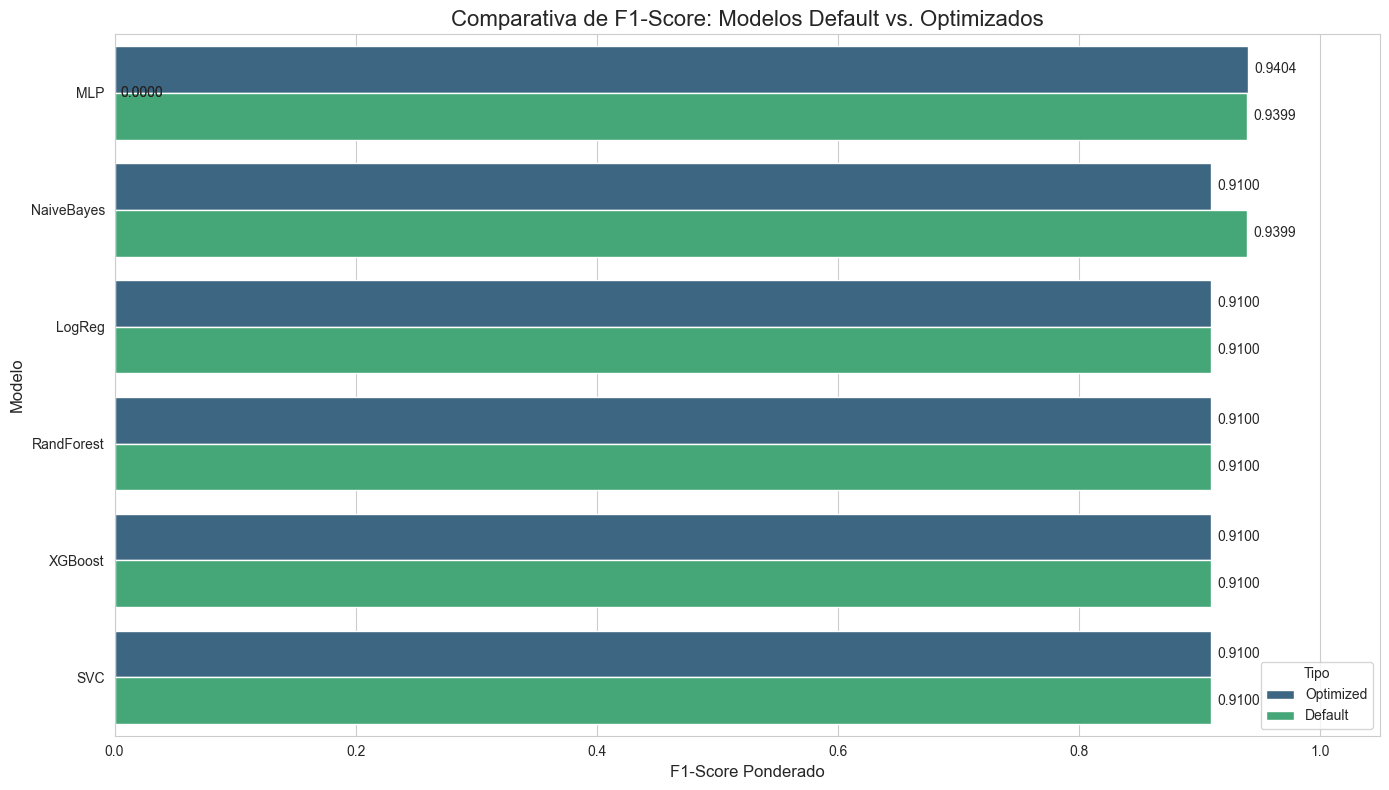

In [7]:
print('--- 7. Visualización Comparativa ---')
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='F1-Score', y='Model', hue='Type', data=results_df.sort_values('F1-Score', ascending=False), palette='viridis')
plt.title('Comparativa de F1-Score: Modelos Default vs. Optimizados', fontsize=16)
plt.xlabel('F1-Score Ponderado', fontsize=12)
plt.ylabel('Modelo', fontsize=12)
plt.legend(title='Tipo')
plt.xlim(0, 1.05)

for p in ax.patches:
    width = p.get_width()
    plt.text(width + 0.005, p.get_y() + p.get_height() / 2, f'{width:.4f}', va='center')

plt.tight_layout()
plt.show()

In [8]:
print('--- 8. Análisis de Importancia de Características ---')
best_overall_model_info = results_df.loc[results_df['F1-Score'].idxmax()]
best_model_name = best_overall_model_info['Model']
best_model_instance = best_models_optimized[best_model_name]

print(f'El mejor modelo global es: {best_model_name} (Optimizado)')

ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = list(numerical_features) + list(ohe_feature_names)

importances = np.zeros(len(all_feature_names))
if hasattr(best_model_instance, 'feature_importances_'):
    importances = best_model_instance.feature_importances_
elif hasattr(best_model_instance, 'coef_'):
    if best_model_instance.coef_.ndim > 1:
        importances = np.mean(np.abs(best_model_instance.coef_), axis=0)
    else:
        importances = np.abs(best_model_instance.coef_[0])

feature_importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

if not feature_importance_df.empty and feature_importance_df['Importance'].sum() > 0:
    plt.figure(figsize=(12, 10))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='rocket')
    plt.title(f'Top 15 Características más Importantes - {best_model_name} Optimizado', fontsize=16)
    plt.xlabel('Importancia', fontsize=12)
    plt.ylabel('Característica', fontsize=12)
    plt.show()
else:
    print(f'No se pudo generar el gráfico de importancia de características para el modelo {best_model_name}.')

--- 8. Análisis de Importancia de Características ---
El mejor modelo global es: MLP (Optimizado)
No se pudo generar el gráfico de importancia de características para el modelo MLP.


Cargando y preparando los datos...
Creando perfiles de estudiantes mediante clustering...
Entrenando el modelo XGBoost...
Extrayendo y visualizando la importancia de las características...

--- Top 10 Características más Importantes ---
                                             Feature  Importance
12        Q31_Data analysis through machine learning    0.397686
8                 Q10_Specialize in a knowledge area    0.166645
7              Q10_Solve problems of social interest    0.124450
14  Q31_Graphic interface design and user experience    0.122282
6                             Q10_Learn meaningfully    0.077210
10               Q30_Improve my academic performance    0.037256
1                                                 Q7    0.025679
2                                                 Q8    0.015507
3                                                 Q9    0.012546
0                                                 Q5    0.008243


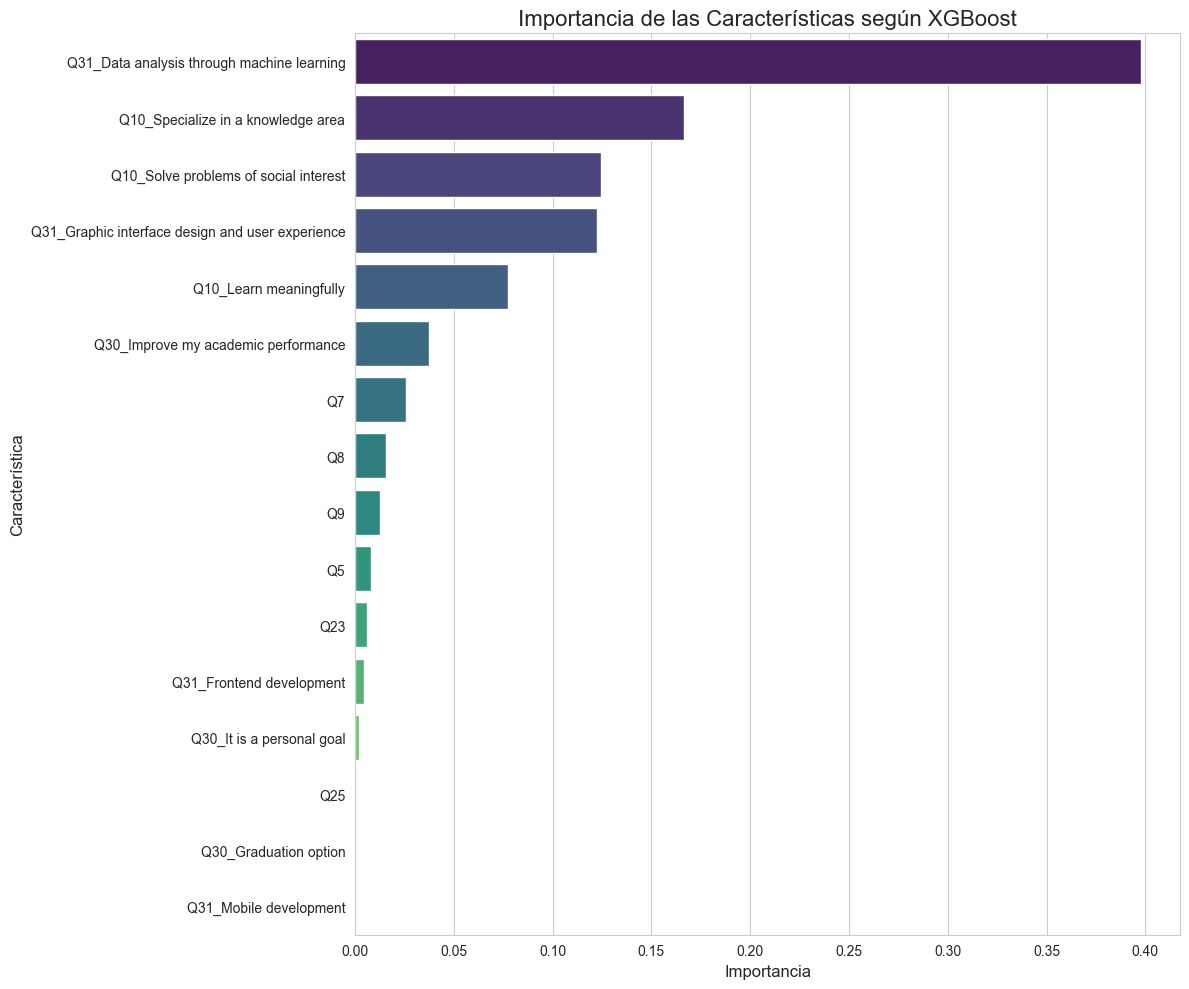

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture
from xgboost import XGBClassifier

# --- Configuración Inicial ---
# Ignorar warnings para una salida más limpia
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
# Estilo de las gráficas
sns.set_style('whitegrid')


# --- 1. Carga y Preparación de Datos ---
print("Cargando y preparando los datos...")
file_path = 'RespuestasSemillero.xlsx'
df = pd.read_excel(file_path)

# Seleccionar las características para el análisis
features = ['Q5', 'Q7', 'Q8', 'Q9', 'Q10', 'Q23', 'Q25', 'Q30', 'Q31']
X = df[features]
# Se usa una columna cualquiera como 'y' temporal solo para poder dividir los datos
y_placeholder = df['Q6'] 

# Dividir los datos ANTES de cualquier procesamiento para evitar fuga de datos
X_train, X_test, _, _ = train_test_split(X, y_placeholder, test_size=0.3, random_state=42)


# --- 2. Creación de la Variable Objetivo (Clustering) ---
print("Creando perfiles de estudiantes mediante clustering...")
# Identificar tipos de columnas
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns
numerical_features = X_train.select_dtypes(include=np.number).columns

# Crear el pipeline de preprocesamiento y clustering
preprocessor = ColumnTransformer(transformers=[
    ('num', MinMaxScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), categorical_features)])

clustering_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clusterer', GaussianMixture(n_components=3, random_state=42))])

# Entrenar el pipeline de clustering SOLO con los datos de entrenamiento
clustering_pipeline.fit(X_train)

# Generar las etiquetas (perfiles) para el conjunto de entrenamiento
y_train = clustering_pipeline.predict(X_train)

# Procesar las características de entrenamiento para el modelo de clasificación
X_train_processed = clustering_pipeline.named_steps['preprocessor'].transform(X_train)


# --- 3. Entrenamiento del Modelo XGBoost ---
print("Entrenando el modelo XGBoost...")
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_processed, y_train)


# --- 4. Extracción y Visualización de la Importancia de Características ---
print("Extrayendo y visualizando la importancia de las características...")
# Obtener las importancias
importances = xgb_model.feature_importances_

# Obtener los nombres de las características después del OneHotEncoding
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = list(numerical_features) + list(ohe_feature_names)

# Crear un DataFrame para facilitar la visualización
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Imprimir el top 10
print("\n--- Top 10 Características más Importantes ---")
print(feature_importance_df.head(10))

# Crear la gráfica
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Importancia de las Características según XGBoost', fontsize=16)
plt.xlabel('Importancia', fontsize=12)
plt.ylabel('Característica', fontsize=12)
plt.tight_layout()
plt.show()